In [33]:
import matplotlib.pyplot as pl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import transforms

from Models.VGG19_model import VGG19

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vgg = VGG19(models.vgg19(weights="VGG19_Weights.DEFAULT"))
vgg.load_state_dict(torch.load("../assets/vgg19_transfer.pth", map_location=device))
vgg.eval()

In [44]:
def explain_with_lime(model: nn.Module, image_path: str, target_class: int) -> None:
    image_transform = transforms.ToTensor()

    image = np.array(Image.open(image_path).convert("RGB").resize((224, 224)))

    def _batch_predict(images: np.ndarray) -> np.ndarray:
        # A function that takes a batch of images and returns a prediction for each image.
        batch = torch.stack(tuple(image_transform(i) for i in images), dim=0)
        batch = batch.to(device)
        logits = model(batch)
        probabilities = F.softmax(logits, dim=1)
        return probabilities.detach().numpy()

    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm("quickshift")
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=_batch_predict,
        segmentation_fn=segmenter,
        num_samples=300,
    )
    image, mask = explanation.get_image_and_mask(
        label=target_class, positive_only=False, num_features=1
    )
    marked_image = mark_boundaries(image / 255.0, mask)
    pl.figure(figsize=(10, 10))
    pl.imshow(marked_image)
    pl.title(image_path)
    pl.axis("off")
    pl.show()

In [49]:
def explain(model: nn.Module, image_path: str, target_class: int) -> None:
    image_transform = transforms.ToTensor()

    image = np.array(Image.open(image_path).convert("RGB").resize((224, 224)))

    def _batch_predict(images: np.ndarray) -> np.ndarray:
        # A function that takes a batch of images and returns a prediction for each image.
        batch = torch.stack(tuple(image_transform(i) for i in images), dim=0)
        batch = batch.to(device)
        logits = model(batch)
        probabilities = F.softmax(logits, dim=1)
        return probabilities.detach().numpy()

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=image, classifier_fn=_batch_predict, num_samples=300
    )
    image, mask = explanation.get_image_and_mask(
        label=target_class, positive_only=False, num_features=2
    )
    marked_image = mark_boundaries(image / 255.0, mask)
    pl.figure(figsize=(10, 10))
    pl.imshow(marked_image)
    pl.title(image_path)
    pl.axis("off")
    pl.show()

In [37]:
images = []

image = Image.open("../assets/compression/meningioma_original.jpg")

image_50_compressed = image.copy()
image_50_compressed.save(
    "../assets/compression/meningioma_50.jpg", quality=50, optimize=True
)

image_1_compressed = image.copy()
image_1_compressed.save(
    "../assets/compression/meningioma_1.jpg", quality=1, optimize=True
)

image_20_compressed = image.copy()
image_20_compressed.save(
    "../assets/compression/meningioma_20.jpg", quality=20, optimize=True
)

images.append("../assets/compression/meningioma_original.jpg")
images.append("../assets/compression/meningioma_50.jpg")
images.append("../assets/compression/meningioma_1.jpg")
images.append("../assets/compression/meningioma_20.jpg")

In [38]:
classes: dict[int, str] = {0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"}

100%|██████████| 300/300 [01:17<00:00,  3.86it/s]


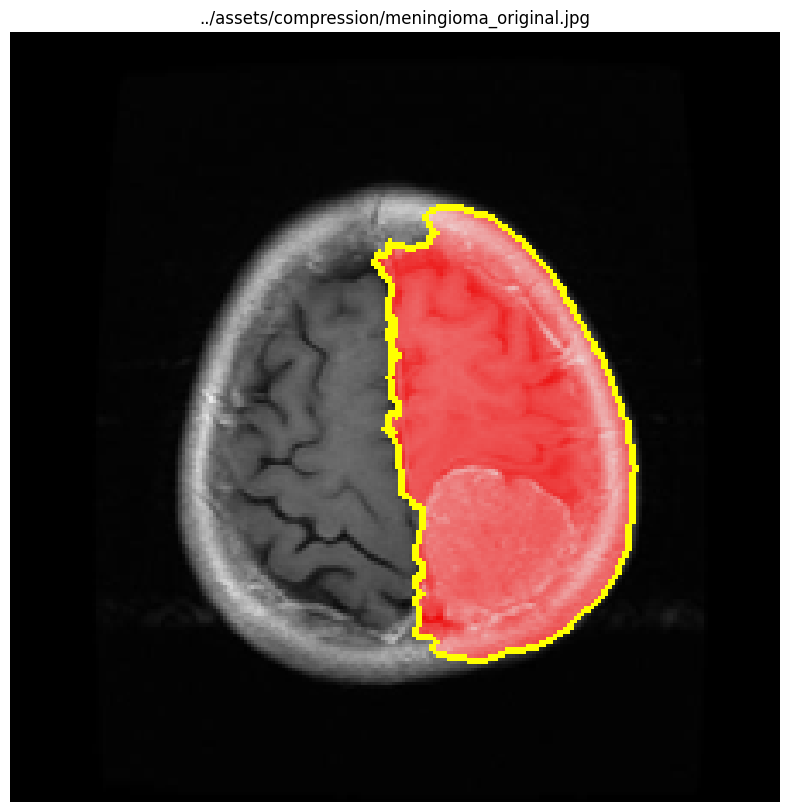

In [50]:
explain(vgg, images[0], 1)

100%|██████████| 300/300 [01:30<00:00,  3.33it/s]


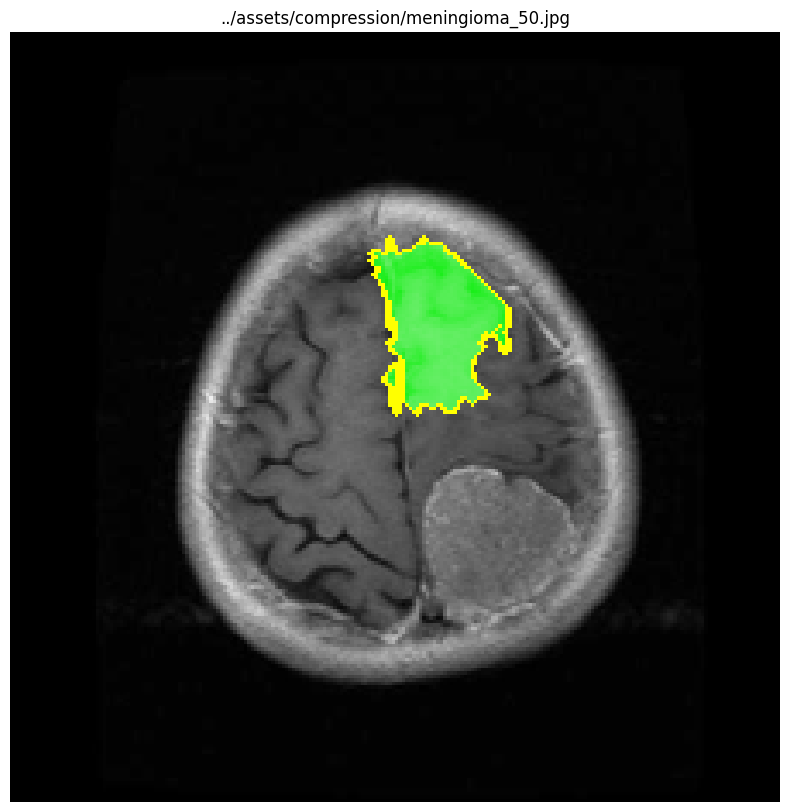

In [46]:
explain_with_lime(vgg, images[1], 1)

100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


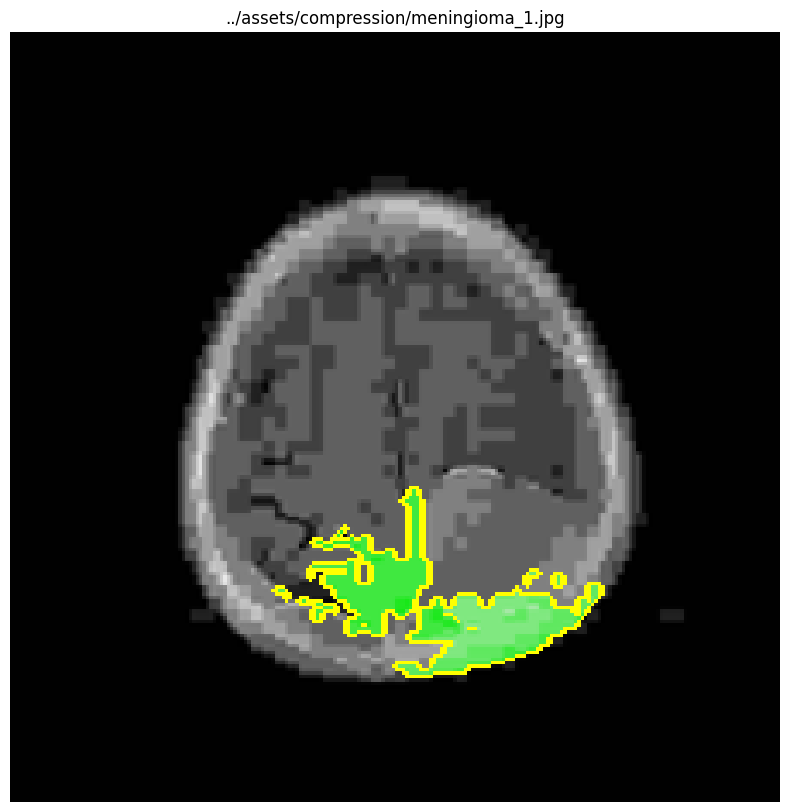

In [41]:
explain_with_lime(vgg, images[2], 1)

100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


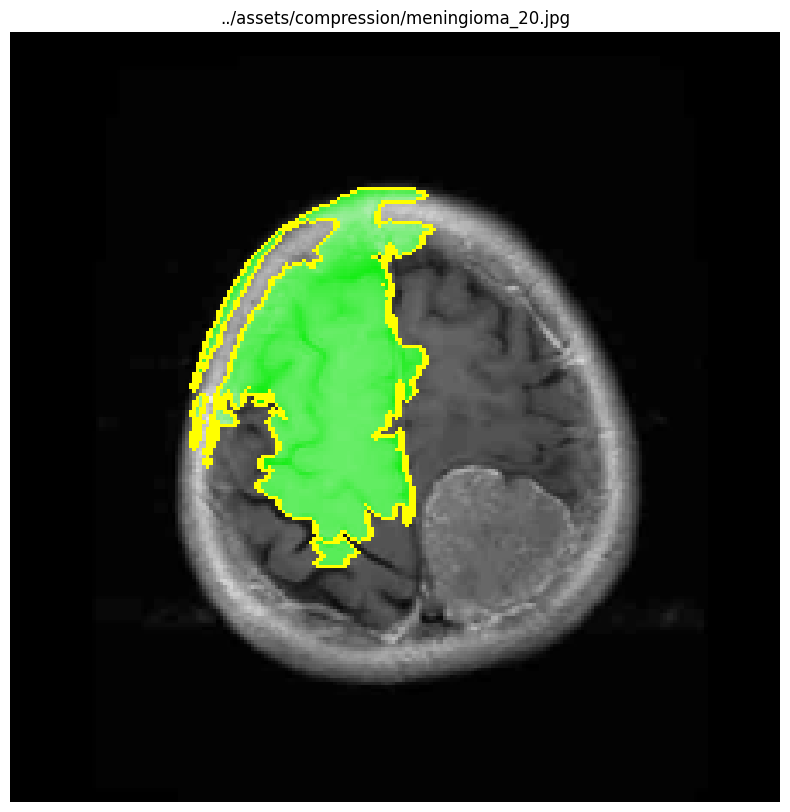

In [42]:
explain_with_lime(vgg, images[3], 1)